# Evaluate pre-trained U-Net model

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

In [ ]:
# # Set directory in Colab -- uncomment this block if you want to run on Colab
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My\ Drive/Colab\ Notebooks/camvid_unet_semantic_segmentation

## 1. Load data to memory

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils import load_data_from_dir

In [ ]:
base_dir = os.getcwd()

train_image_df = pd.read_csv(base_dir + '/data/camvid_train.txt', header=None, sep=' ', names=['image', 'mask'])
val_image_df = pd.read_csv(base_dir + '/data/camvid_val.txt', header=None, sep=' ', names=['image', 'mask'])
test_image_df = pd.read_csv(base_dir + '/data/camvid_test.txt', header=None, sep=' ', names=['image', 'mask'])

classes = [
    'Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree', 
    'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist',
    'Void'
    ]

n_class = 11  # ignore 'Void' (background) class

In [ ]:
%%time
image_dim = (224, 224)  # same as vgg-16
train_images, train_masks = load_data_from_dir(train_image_df, True, image_dim)
val_images, val_masks = load_data_from_dir(val_image_df, True, image_dim)
test_images, test_masks = load_data_from_dir(test_image_df, True, image_dim)

The test set contains 2 individual sequences:
1. `Seq05VD` (Day Test): 171 frames, unseen sequence
2. `0001TP_2` (Dusk Test): 62 frames, first half (`0001TP_1`, 62 frames) is included in training data

In [ ]:
# Load sequences of test data as individual sets -- useful for evaluating model performance in different light conditions
# Load Seq05VD -- 171 frames
test_df_Seq05VD = test_image_df.loc[test_image_df['image'].str.contains("Seq05VD")]
test_images_Seq05VD, test_masks_Seq05VD = load_data_from_dir(test_df_Seq05VD, True, image_dim)

# Load 0001TP_2 -- 62 frames
test_df_0001TP = test_image_df.loc[test_image_df['image'].str.contains("0001TP")]
test_images_0001TP, test_masks_0001TP = load_data_from_dir(test_df_0001TP, True, image_dim)

## 2. Describe dataset

### 2.1 Get category composition percentages by pixels

In [ ]:
masks = test_masks
# masks = test_masks_Seq05VD
# masks = test_masks_0001TP

unique, counts = np.unique(masks, return_counts=True)
total = sum(counts)

dict(zip(classes, (counts/total).round(3)))

### 2.2 Show images and masks

<div>
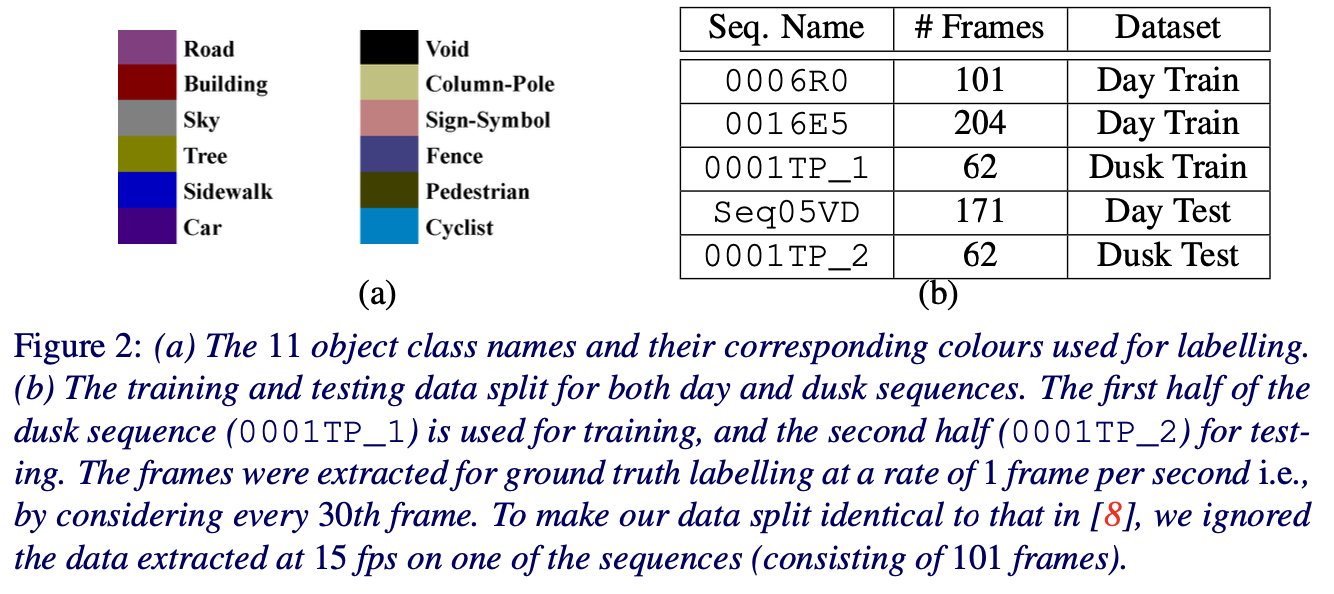
</div>

Figure from [*Sturgess et al (2009) Combining Appearance and Structure from Motion Features for Road Scene Understanding*](https://www.robots.ox.ac.uk/~lubor/bmvc09.pdf)

In [ ]:
from utils import convert_indexed_to_rgb_mask

i = 0

fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].imshow(val_images[i], vmin=0, vmax=1)
ax[0].set_xlabel('image')
ax[1].imshow(convert_indexed_to_rgb_mask(val_masks[i])) 
ax[1].set_xlabel('mask')
ax[2].imshow(val_masks[i] == 255, cmap='binary')
ax[2].set_xlabel('mask (ignored)')
plt.show()

## 3. Load trained model

In [ ]:
model_name = 'unet_filters_64_2x2_upconv.h5'

model = tf.keras.models.load_model(os.path.join(base_dir, 'models', model_name))

## 4. Evaluate model

In [ ]:
images = test_images
masks = test_masks
# images = test_images_Seq05VD
# masks = test_masks_Seq05VD
# images = test_images_0001TP
# masks = test_masks_0001TP

In [ ]:
model.evaluate(images, masks)

masks_pred = model.predict(images)
masks_pred = np.expand_dims(np.argmax(masks_pred, axis=-1), -1)

# Assign values in void regions to 255
masks_pred[masks == 255] = 255

### 4.1 Plot predicted masks

In [ ]:
i = 0

fig, ax = plt.subplots(1,3, figsize=(15,6), dpi=100)
ax[0].imshow(images[i], vmin=0, vmax=1)
ax[0].set_xlabel('image')
ax[1].imshow(convert_indexed_to_rgb_mask(masks[i]))
ax[1].set_xlabel('true mask')
ax[2].imshow(convert_indexed_to_rgb_mask(masks_pred[i]))
ax[2].set_xlabel('predicted mask')
plt.show()

### 4.2 Evaluate pixel-wise accuracy

<div>
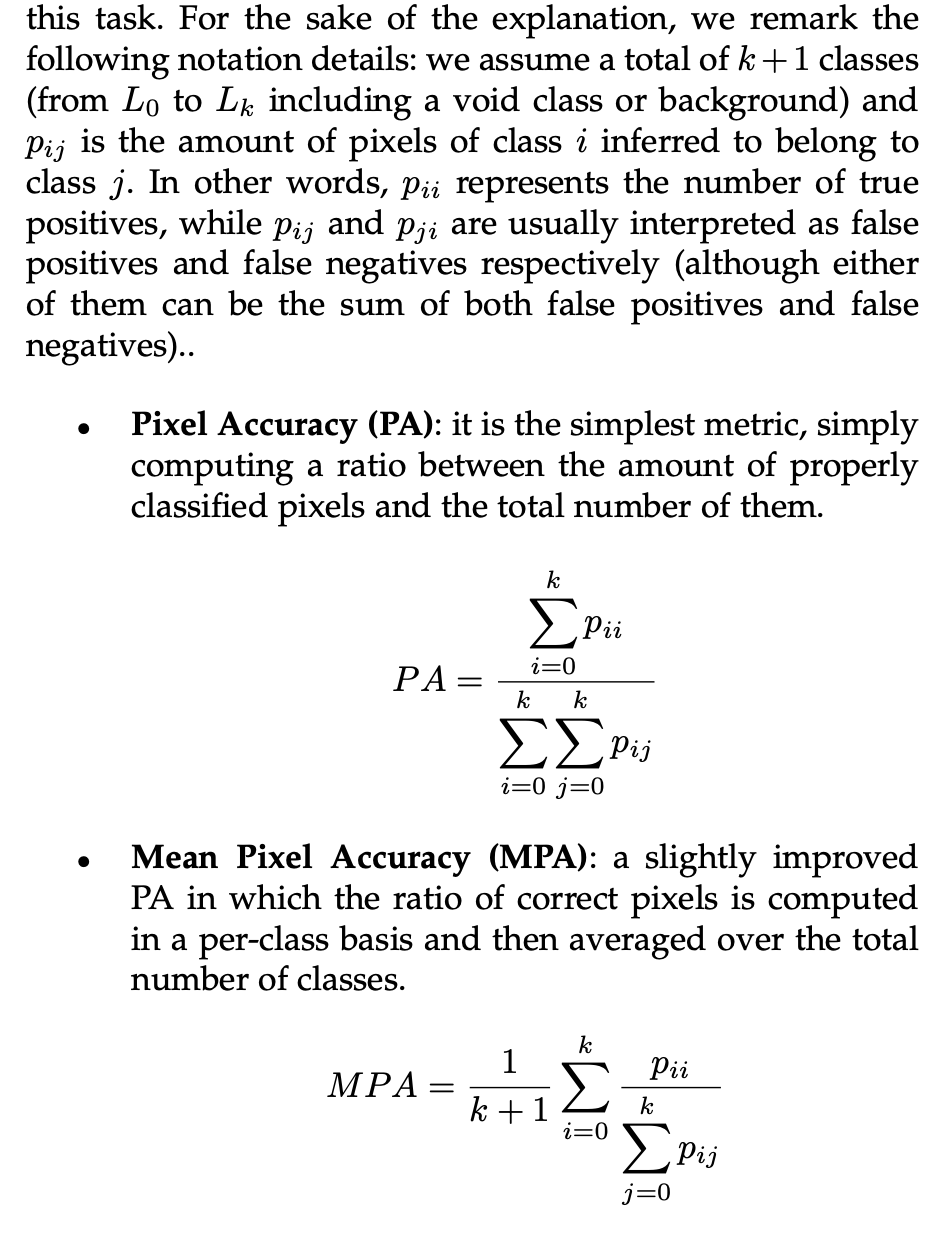
</div>

From [*Garcia-Garcia et al (2017) A Review on Deep Learning Techniques Applied to Semantic Segmentation*](https://arxiv.org/abs/1704.06857)

In [ ]:
from utils import evaluate_pixel_accuracy_by_class, evaluate_pixel_accuracy_global

# Pixel accuracy by class
class_acc = np.zeros(n_class)
for i in range(n_class):
    class_acc[i] = evaluate_pixel_accuracy_by_class(masks, masks_pred, i_class=i)*100
    
# Global average    
global_acc = evaluate_pixel_accuracy_global(masks, masks_pred)*100

print('Pixel-wise accuracy:')
for i in range(n_class):
    print(str(i) + '. ' + classes[i] + ': {:.1f}'.format(class_acc[i]))
print('Class avg: {:.1f}'.format(class_acc[:11].sum()/12))
print('Global avg: {:.1f}'.format(global_acc))

### 4.3 Evaluate intersection-over-union (IOU or Jaccard score)

In [ ]:
from utils import evaluate_jaccard_score_by_class

iou = np.zeros(n_class)
for i in range(n_class):
    iou[i] = evaluate_jaccard_score_by_class(masks, masks_pred, i_class=i)

print('Test set IOU by class:')
for i in range(n_class):
    print(classes[i] + ': ' + str(iou[i].round(2)))
print('11-category mIOU:' + str(iou[:11].mean().round(2)))

## 5. Make animation

In [ ]:
from utils import convert_indexed_to_rgb_masks
import imageio

masks_pred_rgb = convert_indexed_to_rgb_masks(masks_pred)
masks_rgb = convert_indexed_to_rgb_masks(masks)
images_uint8 = (images*255).astype('uint8')

imgs = np.concatenate([images_uint8, 
                cv2.addWeighted(images_uint8, 0.5, masks_rgb, 0.5, 0),
                cv2.addWeighted(images_uint8, 0.5, masks_pred_rgb, 0.5, 0)], axis=2)

filename = 'animation.gif'
imageio.mimsave(filename, imgs, fps=7)